# Seismic petrophysics, part 2

In [part 1](http://nbviewer.ipython.org/github/seg/tutorials/blob/master/1504_Seismic_petrophysics_1/Seismic_petrophysics_1.ipynb) we loaded some logs and used a data framework called Pandas pandas to manage them. We made a lithology–fluid class (LFC) log, and used it to color a crossplot. This time, we take the workflow further with fluid replacement modeling based on Gassmann’s equation. This is just an introduction; see Wang (2001) and Smith et al. (2003) for comprehensive overviews.

## Fluid replacement modeling

Fluid replacement modeling (FRM in short), based on Gassmann's equation, is one of the key activities for any kind of quantitative work (see Wang, 2001 and Smith et al., 2003, for an exhaustive overview).

It is used to model the response of elastic logs (i.e., Vp, Vs and density) in different fluid conditions, thus allowing to study how much a rock would change in terms of velocity (or impedances) if it was filled with gas instead of brine for example; but what it also does is to bring all elastic logs to a *common fluid denominator* to focus only on lithological variations, disregarding fluid effects.

The inputs to FRM are $k_s$ and $\mu_s$ (saturated bulk and shear moduli which we can get from recorded Vps, Vs and density logs), $k_d$ and $\mu_d$ (dry-rock bulk and shear moduli), $k_0$ (mineral bulk modulus), $k_f$ (fluid bulk modulus) and porosity, $\varphi$. Reasonable estimates of mineral and fluid bulk moduli and porosity are easily computed and are shown below. The real unknowns, what is arguably the core issue of rock physics, are the dry-rock moduli.

And here we come to Gassmann's equation; I can use it in its inverse form to calculate $k_d$:

$$ k_d = \frac{k_s \cdot ( \frac{\varphi k_0}{k_f} +1-\varphi) -k_0}{\frac {\varphi k_0}{k_f} + \frac{k_s}{k_0} -1-\varphi} $$

Then I use Gassmann's again in its direct form to calculate the saturated bulk modulus with the new fluid:

$$k_s = k_d + \frac { (1-\frac{k_d}{k_0})^2} { \frac{\varphi}{k_f} + \frac{1-\varphi}{k_0} - \frac{k_d}{k_0^2}}$$

Shear modulus is not affected by pore fluid so that it stays unmodified throughout the fluid replacement process.

$$\mu_s = \mu_d$$

Bulk density is defined via the following equation:

$$\rho = (1-\varphi) \cdot \rho_0 + \varphi \cdot \rho_f $$

We can put all this together into a Python function, calculating the elastic parameters for fluid 2, given the parameters for fluid 1, along with some other data about the fluids:

In [1]:
def frm(vp1, vs1, rho1, rho_f1, k_f1, rho_f2, k_f2, k0, phi):
    vp1  = vp1 / 1000.
    vs1  = vs1 / 1000.
    mu1  = rho1 * vs1**2.
    k_s1 = rho1 * vp1**2 - (4./3.)*mu1
    
    # The dry rock bulk modulus
    kdry = (k_s1 * ((phi*k0)/k_f1+1-phi)-k0) / ((phi*k0)/k_f1+(k_s1/k0)-1-phi)

    # Now we can apply Gassmann to get the new values
    k_s2 = kdry + (1- (kdry/k0))**2 / ( (phi/k_f2) + ((1-phi)/k0) - (kdry/k0**2) )
    rho2 = rho1-phi * rho_f1+phi * rho_f2
    mu2  = mu1
    vp2  = np.sqrt(((k_s2+(4./3)*mu2))/rho2)
    vs2  = np.sqrt((mu2/rho2))

    return vp2*1000, vs2*1000, rho2, k_s2

What this function does is to get the relevant inputs which are:

* `vp1`, `vs1`, `rho1`: measured Vp, Vs, and density (saturated with fluid 1)
* `rho_fl1`, `k_fl1`: density and bulk modulus of fluid 1
* `rho_fl2`, `k_fl2`: density and bulk modulus of fluid 2
* `k0`: mineral bulk modulus
* `phi`:  porosity

And returns `vp2`,`vs2`, `rho2`, `k2` which are respectively Vp, Vs, density and bulk modulus of rock with fluid 2.  Velocities are in m/s and densities in g/cm3.

I have mentioned above the possibility to get estimates of mineral bulk modulus $k_0$; the thing to know is that another assumption in Gassmann's equation is that it works only on monomineralic rocks; an actual rock is always a mixture of different minerals. A good approximation to get a mixed mineralogy bulk modulus `k0` is to use Voigt-Reuss-Hill averaging (check [these notes](https://pangea.stanford.edu/courses/gp262/Notes/9.EffectiveMediumTheories.pdf) by [Jack Dvorkin](http://pangea.stanford.edu/~jack/) for a more rigorous discussion or [this wikipedia entry](http://en.wikipedia.org/wiki/Rule_of_mixtures)).

So I define another function, `vrh`, to do that:

In [2]:
def vrh(volumes,k,mu):
    f = np.array(volumes).T
    k = np.resize(np.array(k),np.shape(f))
    mu = np.resize(np.array(mu),np.shape(f))

    k_u = np.sum(f*k, axis=1)
    k_l = 1. / np.sum(f/k, axis=1)
    mu_u = np.sum(f*mu, axis=1)
    mu_l = 1. / np.sum(f/mu, axis=1)
    k0 = (k_u+k_l) / 2.
    mu0 = (mu_u+mu_l) / 2.
    return k_u, k_l, mu_u, mu_l, k0, mu0

I can use the same function to also compute the fluid bulk modulus log which is usually done via Reuss average (the lower bound `k_l` in the `vrh` function above):

First I will load the Well 2 logs with the litho-fluid class log created in Part 1, then define the various mineral and fluid elastic constants:

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

logs = pd.read_csv('qsiwell2_lfc.csv')

rho_qz=2.65;  k_qz=37;  mu_qz=44    # mineral properties, quartz (i.e., sands)
rho_sh=2.81;  k_sh=15;  mu_sh=5     # mineral properties, clay (i.e., shales)
rho_b=1.09;   k_b=2.8               # fluid properties, brine
rho_o=0.78;   k_o=0.94              # fluid properties, oil
rho_g=0.25;   k_g=0.06              # fluid properties, gas

Then I  calculate the original (insitu) fluid density `rho_fl` and bulk modulus `k_fl`, and the average mineral bulk modulus `k0`:

In [4]:
# mineral mixture bulk and shear moduli, k0 and mu0
shale = logs.VSH.values
sand = 1 - shale - logs.PHI.values
shaleN = shale / (shale+sand)  # normalized shale and sand volumes
sandN  = sand / (shale+sand)
k_u, k_l, mu_u, mu_l, k0, mu0 = vrh([shaleN, sandN], [k_sh, k_qz], [mu_sh, mu_qz])

# fluid mixture bulk modulus, using the same vrh function but capturing the Reuss average (second output)
water = logs.SW.values
hc = 1 - logs.SW.values
tmp, k_fl, tmp, tmp, tmp, tmp = vrh([water, hc], [k_b, k_o], [0, 0])

# fluid mixture density
rho_fl = water*rho_b + hc*rho_o

...and put it all together using the `frm` function defined above:

In [5]:
vpb, vsb, rhob, kb = frm(logs.VP, logs.VS, logs.RHO, rho_fl, k_fl, rho_b, k_b, k0, logs.PHI)
vpo, vso, rhoo, ko = frm(logs.VP, logs.VS, logs.RHO, rho_fl, k_fl, rho_o, k_o, k0, logs.PHI)
vpg, vsg, rhog, kg = frm(logs.VP, logs.VS, logs.RHO, rho_fl, k_fl, rho_g, k_g, k0, logs.PHI)

Now I create 3 sets of copies of the original elastic logs stored in my DataFrame `logs` (`logs.VP`, `logs.VSB`, `logs.RHO`) for the three fluid scenarios investigated (and I will append an appropriate suffix to identify these 3 cases, i.e. `_FRMB` for brine, `_FRMG` for gas and `_FRMO` for oil, respectively). These three sets will be placeholders to store the values of the actual fluid-replaced logs (`vpb`, `vsb`, `rhob`, etc.).

To do that I need once more to define the flag logs `brine_sand`, `oil_sand` and `shale` as discussed in Part 1:

In [6]:
sand_cutoff = 0.20
brine_sand = ((logs.VSH <= sand_cutoff) & (logs.SW >= 0.9))
oil_sand = ((logs.VSH <= sand_cutoff) & (logs.SW < 0.9))
shale = (logs.VSH > sand_cutoff)

The syntax I use to do this is:

    logs['VP_FRMB'][brine_sand|oil_sand]=vpb[brine_sand|oil_sand]
    
Which means, copy the values from the output of fluid replacement (`vpb`, `vsb`, `rhob`, etc.) only where there's sand (`vpb[brine_sand|oil_sand]`), i.e. only when either the flag logs `brine_sand` or `oil_sand` are _True_).

I also compute the additional elastic logs (acoustic and shear impedances `IP`, `Is`, and Vp/Vs ratio, `VPVS`) in their fluid-replaced version.

In [7]:
logs['VP_FRMB'] = logs.VP
logs['VS_FRMB'] = logs.VS
logs['RHO_FRMB'] = logs.RHO
logs['VP_FRMB'][brine_sand|oil_sand] = vpb[brine_sand|oil_sand]
logs['VS_FRMB'][brine_sand|oil_sand] = vsb[brine_sand|oil_sand]
logs['RHO_FRMB'][brine_sand|oil_sand] = rhob[brine_sand|oil_sand]
logs['IP_FRMB'] = logs.VP_FRMB*logs.RHO_FRMB
logs['IS_FRMB'] = logs.VS_FRMB*logs.RHO_FRMB
logs['VPVS_FRMB'] = logs.VP_FRMB/logs.VS_FRMB

logs['VP_FRMO'] = logs.VP
logs['VS_FRMO'] = logs.VS
logs['RHO_FRMO'] = logs.RHO
logs['VP_FRMO'][brine_sand|oil_sand] = vpo[brine_sand|oil_sand]
logs['VS_FRMO'][brine_sand|oil_sand] = vso[brine_sand|oil_sand]
logs['RHO_FRMO'][brine_sand|oil_sand] = rhoo[brine_sand|oil_sand]
logs['IP_FRMO'] = logs.VP_FRMO*logs.RHO_FRMO
logs['IS_FRMO'] = logs.VS_FRMO*logs.RHO_FRMO
logs['VPVS_FRMO'] = logs.VP_FRMO/logs.VS_FRMO

logs['VP_FRMG'] = logs.VP
logs['VS_FRMG'] = logs.VS
logs['RHO_FRMG'] = logs.RHO
logs['VP_FRMG'][brine_sand|oil_sand] = vpg[brine_sand|oil_sand]
logs['VS_FRMG'][brine_sand|oil_sand] = vsg[brine_sand|oil_sand]
logs['RHO_FRMG'][brine_sand|oil_sand] = rhog[brine_sand|oil_sand]
logs['IP_FRMG'] = logs.VP_FRMG*logs.RHO_FRMG
logs['IS_FRMG'] = logs.VS_FRMG*logs.RHO_FRMG
logs['VPVS_FRMG'] = logs.VP_FRMG/logs.VS_FRMG

Finally, I will add three more LFC logs that will be companions to the new fluid-replaced logs. 

The LFC log for brine-replaced logs will be always 1 whenever there's sand, because fluid replacement will have acted on all sand points and replaced whatever fluid we had originally with brine. Same thing for `LFC_O` and `LFC_G` (LFC for oil and gas-replaced logs): they will always be equal to 2 (oil) or 3 (gas) for all the sand samples. That translates into Python like:

In [8]:
temp_lfc_b = np.zeros(np.shape(logs.VSH))
temp_lfc_b[brine_sand.values | oil_sand.values] = 1  # LFC is 1 when either brine_sand (brine sand flag) or oil_sand (oil) is True
temp_lfc_b[shale.values] = 4                # LFC 4=shale
logs['LFC_B'] = temp_lfc_b

temp_lfc_o = np.zeros(np.shape(logs.VSH))
temp_lfc_o[brine_sand.values | oil_sand.values] = 2  # LFC is now 2 when there's sand (brine_sand or oil_sand is True)
temp_lfc_o[shale.values] = 4                # LFC 4=shale
logs['LFC_O'] = temp_lfc_o

temp_lfc_g = np.zeros(np.shape(logs.VSH))
temp_lfc_g[brine_sand.values | oil_sand.values] = 3  # LFC 3=gas sand
temp_lfc_g[shale.values] = 4                # LFC 4=shale
logs['LFC_G'] = temp_lfc_g

And this is the same summary plot that I have used above, updated to show the fluid changes in the elastic logs Ip and Vp/Vs. It is also zoomed into the reservoir between 2150 and 2200 m, and the LFC log is the original one, i.e. it reflects the insitu case.

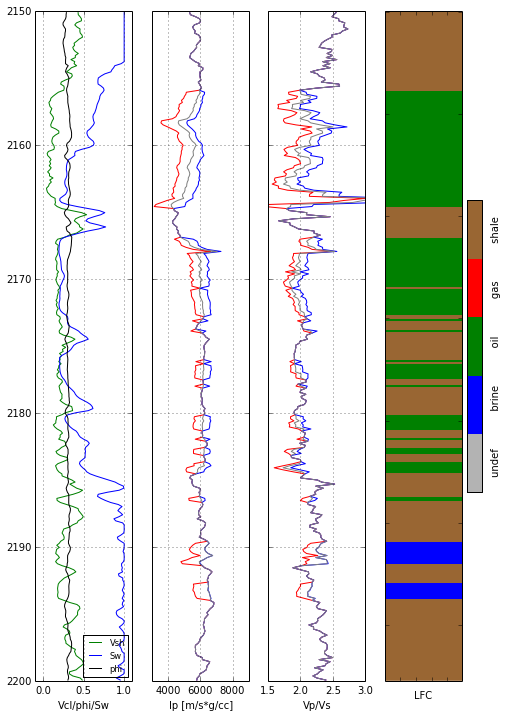

In [9]:
import matplotlib.colors as colors
#      0=undef   1=bri  2=oil   3=gas 4=shale
ccc = ['#B3B3B3','blue','green','red','#996633',]
cmap_facies = colors.ListedColormap(ccc[0:len(ccc)], 'indexed')

ztop = 2150; zbot = 2200
ll = logs.ix[(logs.DEPTH>=ztop) & (logs.DEPTH<=zbot)]

cluster=np.repeat(np.expand_dims(ll['LFC'].values,1),100,1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 12))
ax[0].plot(ll.VSH, ll.DEPTH, '-g', label='Vsh')
ax[0].plot(ll.SW, ll.DEPTH, '-b', label='Sw')
ax[0].plot(ll.PHI, ll.DEPTH, '-k', label='phi')
ax[1].plot(ll.IP_FRMG, ll.DEPTH, '-r')
ax[1].plot(ll.IP_FRMB, ll.DEPTH, '-b')
ax[1].plot(ll.IP, ll.DEPTH, '-', color='0.5')
ax[2].plot(ll.VPVS_FRMG, ll.DEPTH, '-r')
ax[2].plot(ll.VPVS_FRMB, ll.DEPTH, '-b')
ax[2].plot(ll.VPVS, ll.DEPTH, '-', color='0.5')
im=ax[3].imshow(cluster, interpolation='none', aspect='auto',cmap=cmap_facies,vmin=0,vmax=4)

cbar=plt.colorbar(im, ax=ax[3])
# cbar.set_label('0=undef,1=brine,2=oil,3=gas,4=shale')
# cbar.set_ticks(range(0,4+1)); 
cbar.set_label((12*' ').join(['undef', 'brine', 'oil', 'gas', 'shale']))
cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')

for i in ax[:-1]:
    i.set_ylim(ztop,zbot)
    i.invert_yaxis()
    i.grid()
    i.locator_params(axis='x', nbins=4)
ax[0].legend(fontsize='small', loc='lower right')
ax[0].set_xlabel("Vcl/phi/Sw"),    ax[0].set_xlim(-.1,1.1)
ax[1].set_xlabel("Ip [m/s*g/cc]"), ax[1].set_xlim(3000,9000)
ax[2].set_xlabel("Vp/Vs"),         ax[2].set_xlim(1.5,3)
ax[3].set_xlabel('LFC')
ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[3].set_xticklabels([]);

Let's have a look at the results in the Ip versus Vp/Vs crossplot domain; I will now plot 4 different plots to compare the initial situation to the results of the 4 fluid replacements:

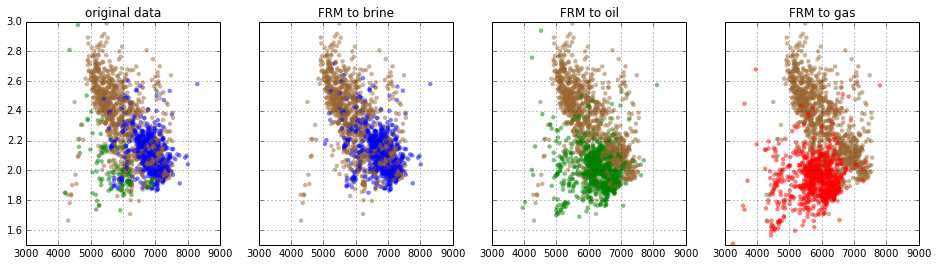

In [10]:
f, ax = plt.subplots(nrows=1, ncols=4, sharey=True, sharex=True, figsize=(16, 4))

ax[0].scatter(logs.IP,logs.VPVS,20,logs.LFC,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[1].scatter(logs.IP_FRMB,logs.VPVS_FRMB,20,logs.LFC_B,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[2].scatter(logs.IP_FRMO,logs.VPVS_FRMO,20,logs.LFC_O,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[3].scatter(logs.IP_FRMG,logs.VPVS_FRMG,20,logs.LFC_G,marker='o',edgecolors='none',alpha=0.5,cmap=cmap_facies,vmin=0,vmax=4)
ax[0].set_xlim(3000,9000); ax[0].set_ylim(1.5,3);
ax[0].set_title('original data');
ax[1].set_title('FRM to brine');
ax[2].set_title('FRM to oil');
ax[3].set_title('FRM to gas');
for i in ax: i.grid()

# statistical analysis

### generalities

After FRM I have created an _augmented_ dataset. What I need to do now is to do a further abstraction, i.e. moving away from the intricacies and local irregularities of the real data with the final goal of creating a fully synthetic dataset representing an idealized version of a reservoir complex.

To do that I will do a statistical analysis to describe [tendency](http://en.wikipedia.org/wiki/Central_tendency), [dispersion](http://en.wikipedia.org/wiki/Statistical_dispersion) and [correlation](http://en.wikipedia.org/wiki/Correlation_and_dependence) between certain elastic properties for each litho-fluid class.

Central tendency is simply described by calculating the mean values of some desired elastic property for all the existing classes; dispersion and correlation are summarised with the _covariance matrix_, which can be written like this (for two generic variables X and Y):

    [ var_X     cov_XY ]
    [ cov_XY    var_Y  ]

if I had _three_ variables instead:

    [ var_X     cov_XY    cov_XZ ]
    [ cov_XY    var_Y     cov_YZ ]
    [ cov_XZ    cov_YZ    var_Z  ]

Where `var_X` is the [variance](http://en.wikipedia.org/wiki/Variance) of property X, i.e. a measure of dispersion about the mean, while the [covariance](http://en.wikipedia.org/wiki/Covariance) `cov_XY` is a measure of similarity between two properties X and Y. A detailed description of the covariance matrix can be found at [this wikipedia entry](http://en.wikipedia.org/wiki/Covariance_matrix).

Python allows me to easily perform these calculations, but what I need is a way to to store this matrix in a way that is easily accessible (which will be another Pandas DataFrame). To do this I first linearize the matrices removing the duplicates, to get something like this (example for the 2-variable scenario):

    var_X  cov_XY  cov_XY var_Y

### implementation in python

For the rest of this exercise I will work with the two variables used so far, i.e. Ip and Vp/Vs.

First I need to prepare a few things to make the procedure easily extendable to other situations (e.g., using more than two variables):

1. collect all the insitu and fluid-replaced logs together to create a _megalog_;
2. create a Pandas DataFrame to hold statistical information for all the litho-fluid classes.

Step 1 works like this:

In [11]:
lognames0 = ['LFC','IP','VPVS']
lognames1 = ['LFC_B','IP_FRMB', 'VPVS_FRMB']
lognames2 = ['LFC_O','IP_FRMO', 'VPVS_FRMO']
lognames3 = ['LFC_G','IP_FRMG', 'VPVS_FRMG']
ww0 = logs[pd.notnull(logs.LFC)].ix[:,lognames0];
ww1 = logs[pd.notnull(logs.LFC)].ix[:,lognames1];  ww1.columns=[lognames0]
ww2 = logs[pd.notnull(logs.LFC)].ix[:,lognames2];  ww2.columns=[lognames0]
ww3 = logs[pd.notnull(logs.LFC)].ix[:,lognames3];  ww3.columns=[lognames0]
ww = pd.concat([ww0, ww1, ww2, ww3])

In [12]:
import itertools
list(itertools.product(['a', 'b'], ['a', 'b']))

[('a', 'a'), ('a', 'b'), ('b', 'a'), ('b', 'b')]

What I have done here is to first define 3 lists containing the names of the logs we want to extract (lines 1-4). Then I extract into 4 separate temporary DataFrames (lines 5-8) different sets of logs, e.g. `ww0` will contain only the logs `LFC`,`IP`,`VPVS`, and `ww1` will hold only `LFC_B`,`IP_FRMB`, `VPVS_FRMB`. I will also rename the fluid-replaced logs to have the same name as my insitu logs using `ww1.columns=[lognames0]`. In this way, when I merge all these 3 DataFrame together (line 9) I will have created a megalog (`ww`) that includes all values of Ip and Vp/Vs that are both measured for a certain facies, and synthetically created through fluid substitution.

In other words, I have now a superpowered, data-augmented megalog.

Now, on to step 2:

In [14]:
nlfc = int(ww.LFC.max())
nlogs = len(ww.columns) - 1   # my merged data always contain a facies log...
                              # ...that needs to be excluded from the statistical analysis
means, covs = [], []

for col in ww.columns[1:]:
    means.append(col + '_mean')

import itertools
covariances = list(itertools.product(ww.columns[1:], ww.columns[1:]))
print covariances

for element in covariances:
    if element[0] == element[1]:
        covs.append(element[0] + '_var')
    else:
        covs.append(element[0] + '-' + element[1] + '_cov')
    
covs

[('IP', 'IP'), ('IP', 'VPVS'), ('VPVS', 'IP'), ('VPVS', 'VPVS')]


['IP_var', 'IP-VPVS_cov', 'VPVS-IP_cov', 'VPVS_var']

With the code above I simply build the headers for a Pandas DataFrame to store mean and covariances for each class.

I will now create a DataFrame which is dynamically dimensioned and made of `nfacies` rows, i.e. one row per each facies, and `1+n+m+1` columns, where `n` is the number of mean columns and `m` is the length of the linearized covariance matrix; for our sample case where we have only two properties this means:

* 1 column to store the facies number;
* 2 columns to store mean values for each of the four logs;
* 3 columns to store variance and covariance values;
* 1 column to store the number of samples belonging to each facies as a way to control the robustness of our statistical analysis (i.e., undersampled classes could be taken out of the study).

In [15]:
stat = pd.DataFrame(data=None,
                    columns=['LFC']+means+covs+['SAMPLES'],
                    index=np.arange(nlfc))
stat['LFC'] = range(1, nlfc+1)

This is how the `stat` DataFrame looks like now:

In [16]:
stat

,LFC,IP_mean,VPVS_mean,IP_var,IP-VPVS_cov,VPVS-IP_cov,VPVS_var,SAMPLES
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
np.math.factorial(3)

6

So it's like an empty box, made of four rows (because we have 4 classes: shale, brine, oil and gas sands), and for each row we have space to store the mean values of property n.1 (Ip) and n.2 (Vp/Vs), plus their covariances and the number of samples for each class (that will inform me on the robustness of the analysis, i.e. if I have too few samples then I need to consider how my statistical analysis will not be reliable).

The following snippet shows how to populate `stat` and get a few plots to control if everything makes sense; also note the use of `.flatten()` at line 5 that linearize the covariance matrix as discussed above, so that I can save it in a series of contiguous cells along a row of `stat`:

In [18]:
for i in range(1, 1+nlfc):
    temp = ww[ww.LFC==i].drop('LFC',1)
    stat.ix[(stat.LFC==i),'SAMPLES'] = temp.count()[0]
    stat.ix[stat.LFC==i,means[0]:means[-1]] = np.mean(temp.values,0)
    stat.ix[stat.LFC==i,covs[0]:covs[-1]] = np.cov(temp,rowvar=0).flatten()
    print (temp.describe().ix['mean':'std'])
    print ("LFC=%d, number of samples=%d" % (i, temp.count()[0]))

               IP      VPVS
mean  6790.205433  2.114032
std    446.901335  0.143257

[2 rows x 2 columns]
LFC=1, number of samples=1546
               IP      VPVS
mean  6184.984928  2.006645
std    581.027454  0.153004

[2 rows x 2 columns]
LFC=2, number of samples=974
               IP      VPVS
mean  5816.300762  1.939004
std    600.000944  0.142885

[2 rows x 2 columns]
LFC=3, number of samples=840
               IP      VPVS
mean  6087.850787  2.316682
std    701.800996  0.237249

[2 rows x 2 columns]
LFC=4, number of samples=4512


Now let's look back at `stat` and see how it has been filled up with all the information I need:    

In [19]:
stat

,LFC,IP_mean,VPVS_mean,IP_var,IP-VPVS_cov,VPVS-IP_cov,VPVS_var,SAMPLES
0,1,6790.205,2.114032,199720.8,-27.95407,-27.95407,0.02052249,1546
1,2,6184.985,2.006645,337592.9,-16.72487,-16.72487,0.02341014,974
2,3,5816.301,1.939004,360001.1,8.667817,8.667817,0.020416,840
3,4,6087.851,2.316682,492524.6,-98.02494,-98.02494,0.05628693,4512


I can also interrogate `stat` to know for example the average Ip for the litho-fluid class 2 (brine sands):

In [20]:
stat.ix[stat.LFC==2, 'VPVS_mean']

1    2.006645
Name: VPVS_mean, dtype: object

Obviously I need to remember that the _first_ property is Ip, so that's why I am querying the column `mean0` (`mean1` holds the average values for the _second_ property, in this case Vp/Vs).

If I were working with 3 properties, e.g. Ip, Vp/Vs and density, then the average density value for a hypothetical class 5 would be: `stat.ix[stat.LFC==5,'mean2']`; remember that Python works with zero-based lists and vectors so the first one has always an index of 0.

To display graphically the same information I use Pandas' `scatter_matrix`:

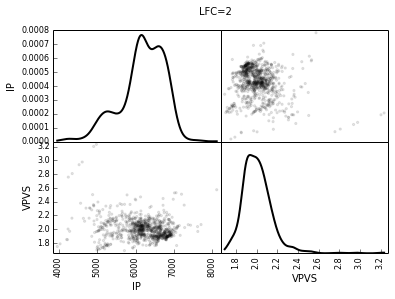

In [21]:
i = 2
pd.scatter_matrix(ww[ww.LFC==i].drop('LFC',1),
                  color='black',
                  diagonal='kde',
                  alpha=0.1,
                  density_kwds={'color':'#000000','lw':2})
plt.suptitle('LFC=%d' % i)

# creation of synthetic datasets

I can now use all this information to create a brand new synthetic dataset that will replicate the average behaviour of the reservoir complex and at the same time overcome typical problems when using real data like undersampling of a certain class, presence of outliers, spurious occurrence of anomalies.

To create the synthetic datasets I use a Monte Carlo simulation relying on [multivariate normal distribution](http://en.wikipedia.org/wiki/Multivariate_normal_distribution) to draw samples that are random but correlated in the elastic domain of choice (Ip and Vp/Vs).

In [28]:
NN = 300

mc = pd.DataFrame(data=None,
                  columns=lognames0,
                  index=np.arange(nlfc*NN),
                  dtype='float')

for i in range(1, nlfc+1):
    mc.loc[NN*i-NN:NN*i-1, 'LFC'] = i

from numpy.random import multivariate_normal
    
for i in range(1, nlfc+1):
    mean = stat.loc[i-1,
                    means[0]:means[-1]].values
    sigma = np.reshape(stat.loc[i-1,
                                covs[0]:covs[-1]].values,
                                (nlogs,nlogs))
    m = multivariate_normal(mean,sigma,NN)
    mc.ix[mc.LFC==i,1:] = m

First I define how many samples per class I want (line 1), then I create an empty Pandas DataFrame (lines 3-5) dimensioned like this:

* as many columns as the elastic logs I have chosen: in this case, 3 (`LFC`, `IP` and `VPVS`, stored in `lognames0`, previously used to dimension the `stat` DataFrame);
* the total number of rows will be equal to number of samples (e.g., 100) multiplied by the number of classes (4).

In lines 7-8 I fill in the `LFC` column with the numbers assigned to each class. I use the `nlfc` variable that contains the total number of classes, introduced earlier when creating the `stat` DataFrame; then I loop over the range 1 to `nlfc` , and assign 1 to rows 1-299, 2 to 300-599, and so on.

Lines 10-13 are the core of the entire procedure. For each class (another loop over the range 1-`nlfc`) I extract the average value `mean` and the covariance matrix `sigma` from the `stat` DataFrame, then put them into the [Numpy](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.multivariate_normal.html) `np.random.multivariate_normal` method to draw randomly selected samples from the continuous and correlated distributions of the properties Ip and Vp/Vs.

So the `mc` DataFrame will be made of 3 columns (`LFC`, `IP`, `VPVS`) by 1200 rows (we can look at the dimensions with `.shape` and then have an overview of the matrix with `.describe` discussed earlier):

In [29]:
mc.describe()

,LFC,IP,VPVS
count,1200.0000,1200.000000,1200.000000
mean,2.5000,6200.486149,2.096580
std,1.1185,685.177176,0.227678
min,1.0000,4051.760372,1.560042
25%,1.7500,5739.186776,1.942134
50%,2.5000,6242.775765,2.080565
75%,3.2500,6720.442317,2.220722
max,4.0000,8042.359755,2.941768


And these are the results, comparing the original, augmented dataset (i.e. the results of fluid replacement merged with the insitu log, all stored in the DataFrame `ww` defined earlier when calculating the statistics) with the newly created synthetic data:

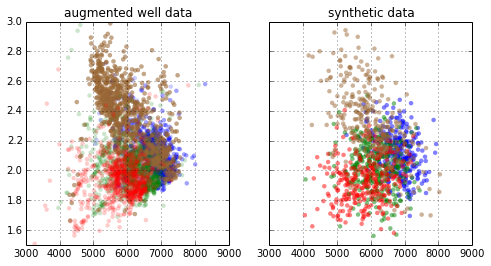

In [30]:
f, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(8, 4))
scatt1 = ax[0].scatter(ww.IP, ww.VPVS,
                       s=20,
                       c=ww.LFC,
                       marker='o',
                       edgecolors='none',
                       alpha=0.2,
                       cmap=cmap_facies,
                       vmin=0,vmax=4)
scatt2 = ax[1].scatter(mc.IP, mc.VPVS,
                       s=20,
                       c=mc.LFC,
                       marker='o',
                       edgecolors='none',
                       alpha=0.5,
                       cmap=cmap_facies,
                       vmin=0,vmax=4)
ax[0].set_xlim(3000,9000); ax[0].set_ylim(1.5,3.0);
ax[0].set_title('augmented well data');
ax[1].set_title('synthetic data');
for i in ax: i.grid()

# Go interactive!

One very cool feature of these IPython notebooks, is the possibility to go interactive. I have created a [separate notebook](http://nbviewer.ipython.org/github/aadm/Wellmagic/blob/master/Synthetic%20data%20generation%20interactive.ipynb)  available for download in the github repo [https://github.com/aadm/Wellmagic](https://github.com/aadm/Wellmagic).

# References

* Avseth, P., Mukerji, T. & Mavko, G. Quantitative Seismic Interpretation. (Cambridge University Press, 2005).
* Chambers, R., Yarus, J. & Hird, K. Petroleum geostatistics for nongeostatisticians - Part 1. The Leading Edge (2000).
* Mavko, G., Mukerji, T. & Dvorkin, J. The Rock Physics Handbook. (Cambridge University Press, 2009).
* Mukerji, T., Avseth, P., Mavko, G., Takahashi, I. & González, E. F. Statistical rock physics : Combining rock physics , information theory , and geostatistics to reduce uncertainty in seismic reservoir characterization. The Leading Edge 313–319 (2001).
* Smith, T. M., Sondergeld, C. H. & Rai, C. S. Gassmann fluid substitutions : A tutorial. Geophysics 68, 430–440 (2003).
* Wang, Z. Z. Fundamentals of seismic rock physics. Geophysics 66, 398–412 (2001).

See also the awesome collection of tutorials curated by Matt Hall for [The Leading Edge](http://library.seg.org/journal/leedff) and available here: <https://github.com/seg/tutorials>